In [5]:

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.utils import plot_model


2.15.0


In [6]:
import numpy as np
import re
import string
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk


In [7]:

from google.colab import files
uploaded = files.upload()


Saving blue_castle.txt to blue_castle (1).txt


In [8]:
file = open("blue_castle.txt", "r", encoding = "utf8" )

#store file in list
lines = []
for i in file:
     lines.append(i)

#Convert list to string
data = ""
for i in lines:
    data = '  '. join(lines)

#replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space

#remove unnecessary spaces
data = data.split()
data = ' '.join(data)
data[:500]

'The Project Gutenberg eBook of The Blue Castle, by Lucy Maud Montgomery This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before usi'

In [9]:
len(data)


402906

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

#saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl','wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[1, 112, 97, 587, 4, 1, 94, 147, 58, 2383, 2384, 1818, 51, 587, 42]

In [11]:
len(sequence_data)


72052

In [12]:

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)


8413


In [13]:
sequences = []

for i in range (3, len(sequence_data)):
  words = sequence_data[i-3:i+1]
  sequences.append(words)

print("The Length if sequences are:" , len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length if sequences are: 72049


array([[   1,  112,   97,  587],
       [ 112,   97,  587,    4],
       [  97,  587,    4,    1],
       [ 587,    4,    1,   94],
       [   4,    1,   94,  147],
       [   1,   94,  147,   58],
       [  94,  147,   58, 2383],
       [ 147,   58, 2383, 2384],
       [  58, 2383, 2384, 1818],
       [2383, 2384, 1818,   51]])

In [14]:

X = []
y = []

for i in sequences:
  X.append(i[0:3])
  y.append(i[3])

X = np.array(X)
y = np.array(y)


In [15]:
print("Data:", X[:10])
print("Response:", y[:10])

Data: [[   1  112   97]
 [ 112   97  587]
 [  97  587    4]
 [ 587    4    1]
 [   4    1   94]
 [   1   94  147]
 [  94  147   58]
 [ 147   58 2383]
 [  58 2383 2384]
 [2383 2384 1818]]
Response: [ 587    4    1   94  147   58 2383 2384 1818   51]


In [16]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(200))
model.add(Dense(1000, activation= "relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [27]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 10)             84130     
                                                                 
 lstm_4 (LSTM)               (None, 3, 200)            168800    
                                                                 
 lstm_5 (LSTM)               (None, 200)               320800    
                                                                 
 dense_3 (Dense)             (None, 1000)              201000    
                                                                 
 dense_4 (Dense)             (None, 8413)              8421413   
                                                                 
Total params: 9196143 (35.08 MB)
Trainable params: 9196143 (35.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


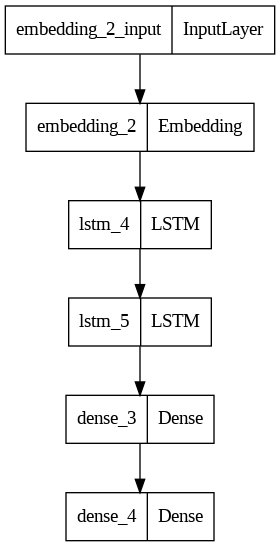

In [28]:
from tensorflow import keras

plot_model(model, to_file='plot.png', show_layer_names=True)

In [29]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [30]:
# Set up callbacks
checkpoint = ModelCheckpoint("next_word.h5", monitor='loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, verbose=1)

# Train model
model.fit(X, y, epochs=80, batch_size=64, callbacks=[checkpoint, early_stopping, reduce_lr])

# Save tokenizer for future use

Epoch 1/80
1126/1126 [==============================] - ETA: 0s - loss: 6.8355 - accuracy: 0.0374
Epoch 1: loss improved from inf to 6.83549, saving model to next_word.h5
1126/1126 [==============================] - 23s 17ms/step - loss: 6.8355 - accuracy: 0.0374 - lr: 0.0010
Epoch 2/80
1126/1126 [==============================] - ETA: 0s - loss: 6.3826 - accuracy: 0.0543
Epoch 2: loss improved from 6.83549 to 6.38262, saving model to next_word.h5
1126/1126 [==============================] - 16s 14ms/step - loss: 6.3826 - accuracy: 0.0543 - lr: 0.0010
Epoch 3/80
1126/1126 [==============================] - ETA: 0s - loss: 6.0096 - accuracy: 0.0838
Epoch 3: loss improved from 6.38262 to 6.00956, saving model to next_word.h5
1126/1126 [==============================] - 16s 14ms/step - loss: 6.0096 - accuracy: 0.0838 - lr: 0.0010
Epoch 4/80
1126/1126 [==============================] - ETA: 0s - loss: 5.6731 - accuracy: 0.1028
Epoch 4: loss improved from 6.00956 to 5.67311, saving model to

In [36]:
import numpy as np
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences


text = "License included with"

for i in range(5):
    # Tokenize the seed text
    token_text = tokenizer.texts_to_sequences([text])[0]

    maxlen = 3
    padded_token_text = pad_sequences([token_text], maxlen=maxlen, padding='pre')
    # Predict the next word
    pos = np.argmax(model.predict(padded_token_text), axis=-1)

    for word, index in tokenizer.word_index.items():
        if index == pos:
            text = text + " " + word
            print(text)
            break
    time.sleep(2)



1/1 [==============================] - 0s 17ms/step
License included with this
1/1 [==============================] - 0s 25ms/step
License included with this ebook
1/1 [==============================] - 0s 18ms/step
License included with this ebook or
1/1 [==============================] - 0s 25ms/step
License included with this ebook or online
1/1 [==============================] - 0s 19ms/step
License included with this ebook or online at


In [37]:
import numpy as np
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences


text = "every member of the family"

for i in range(5):
    # Tokenize the seed text
    token_text = tokenizer.texts_to_sequences([text])[0]

    maxlen = 3
    padded_token_text = pad_sequences([token_text], maxlen=maxlen, padding='pre')
    # Predict the next word
    pos = np.argmax(model.predict(padded_token_text), axis=-1)

    for word, index in tokenizer.word_index.items():
        if index == pos:
            text = text + " " + word
            print(text)
            break
    time.sleep(2)


1/1 [==============================] - 0s 23ms/step
every member of the family would
1/1 [==============================] - 0s 18ms/step
every member of the family would come
1/1 [==============================] - 0s 18ms/step
every member of the family would come down
1/1 [==============================] - 0s 18ms/step
every member of the family would come down and
1/1 [==============================] - 0s 17ms/step
every member of the family would come down and talk
